### Train schedules data from Digitraffic

Data from Digitraffic's [https://rata.digitraffic.fi](https://rata.digitraffic.fi)-interface. License [CC 4.0 BY](http://creativecommons.org/licenses/by/4.0/)


### Weather data from the Finnish Meteorological Insititute
https://en.ilmatieteenlaitos.fi/open-data (MIT license)

---



## Predicting the schedule, multi-layer perceptron

### Select training data, from winter 2016-2017

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

# --------------- TRAINING DATA ----------------- 
training = pd.DataFrame(pd.read_csv('data/JY-HKI-dec16-mar17.csv'))

# Function to convert trip time to seconds!
def ero(row):
    t = pd.to_datetime(row)
    ero = (t-dt.datetime(dt.datetime.now().year, dt.datetime.now().month, dt.datetime.now().day)).total_seconds()
    return ero

training['Trip time'] = training['Trip time'].apply(ero)
training['Sched. trip time'] = training['Sched. trip time'].apply(ero)
training.head(3)

,Unnamed: 0,Timestamp,Train ID,Scheduled,Actual time,Delay,Station,Dep/Arr,Category,Delay at Dep.,Trip time,Sched. trip time,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,0,2016-12-01 16:38:23,86,16:33:00,16:38:23,323,HKI,ARRIVAL,Long-distance,8,12701.0,12720.0,-0.7,0.0,0.0,0.0,-10.8,0.0,0.0,7.0
1,1,2016-12-01 08:52:19,140,08:52:00,08:52:19,19,HKI,ARRIVAL,Long-distance,10,12729.0,12720.0,-0.7,0.0,0.0,0.0,-2.6,0.0,0.0,8.0
2,2,2016-12-01 11:54:53,142,11:52:00,11:54:53,173,HKI,ARRIVAL,Long-distance,77,13236.0,13140.0,-0.7,0.0,0.0,0.0,-4.4,0.0,0.0,8.0


In [3]:
# Get only long-distance trains
training = training.loc[(training['Category'] == 'Long-distance')  & (training['Train ID'] < 10000) ]

# Drop the columns we don't need, and leave the most correlating
training.drop(training.columns[[0,1,2,3,4,6,7,8,5,9]], axis=1, inplace=True)
training = training.reset_index(drop=True)

# Save the column names, we need them after scaling
colnames = training.columns

# train the normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(training)

# Scale dataframe and place column names
training2 = pd.DataFrame(scaler.transform(training), columns=colnames)
training2.head(3)

,Trip time,Sched. trip time,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,-0.547282,-0.409216,0.461255,-1.0,-1.0,-1.0,0.086093,-1.0,-1.0,-0.939394
1,-0.540018,-0.409216,0.461255,-1.0,-1.0,-1.0,0.629139,-1.0,-1.0,-0.878788
2,-0.408484,-0.243797,0.461255,-1.0,-1.0,-1.0,0.509934,-1.0,-1.0,-0.878788


### Select target and training columns for MLP

In [4]:
# ----------------- TARGET ----------------
y = training2.iloc[:,0]                            #y = (y - y.mean())/y.std()  # z-score normalization

# Set training columns = all but 'Delay'
X = training2.loc[:, training2.columns != 'Sched. trip time'] #or:   X = training2.iloc[:, training2.columns != 0]
X.head()

,Trip time,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,-0.547282,0.461255,-1.0,-1.0,-1.0,0.086093,-1.0,-1.0,-0.939394
1,-0.540018,0.461255,-1.0,-1.0,-1.0,0.629139,-1.0,-1.0,-0.878788
2,-0.408484,0.461255,-1.0,-1.0,-1.0,0.509934,-1.0,-1.0,-0.878788
3,-0.348554,0.461255,-1.0,-1.0,-1.0,0.304636,-1.0,-1.0,-0.939394
4,-0.678558,0.453875,-1.0,-1.0,-1.0,0.066225,-1.0,-1.0,-0.939394


### Test data. Predictions for data from winter 2017-2018

In [5]:
# -------------- TESTING DATA ---------------
testing = pd.DataFrame(pd.read_csv('data/JY-HKI-dec17-mar18.csv'))
testing.drop(testing.columns[[0]], axis=1, inplace=True)

#only long-distance trains below id 10000
testing = testing.loc[(testing['Category'] == 'Long-distance')  & (testing['Train ID'] < 10000) ]
testing = testing.reset_index(drop=True)

testing['Trip time'] = testing['Trip time'].apply(ero)
testing['Sched. trip time'] = testing['Sched. trip time'].apply(ero)


# Drop columns (useless for this algorithm)
testdata = testing.copy()
testdata.drop(testing.columns[[0,1,2,3,4,5,6,7,8]], axis=1, inplace=True)

# Scale testdata, use same column names as before
testdata = pd.DataFrame(scaler.transform(testdata), columns=colnames)

# Select all but 'Trip time' column. We can later compare this real delay information to our predictions.
testdata = testdata.loc[:, testdata.columns != 'Trip time']  # or:  testdata = testdata.iloc[:, testdata.columns != 0]
testdata.head()

,Sched. trip time,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,-0.361954,0.527675,0.0,0.682540,-0.333333,0.701987,-0.047619,0.191919,-1.121212
1,-0.361954,0.527675,0.0,0.460317,-0.333333,0.682119,-0.047619,0.212121,-1.121212
2,-0.196534,0.542435,-0.4,-0.047619,-1.000000,0.735099,-0.428571,-0.333333,-1.242424
3,-0.196534,0.527675,0.0,0.492063,-0.500000,0.715232,-0.047619,-0.030303,-1.181818
4,-0.692792,0.527675,0.0,0.714286,-0.500000,0.701987,-0.047619,0.171717,-1.181818


### Prediction
Fit Multi Layer Perceptron to training data, and predict on 'testdata'

In [6]:
max_iter = 200
layers = (5,5)
alphas = 0.1
init = 0.1

# alusta mlp 
mlp = MLPRegressor(verbose=0, random_state=0, max_iter=max_iter, batch_size='auto', activation='identity',
                  learning_rate_init=init, solver='adam', alpha=alphas, hidden_layer_sizes=layers )
mlp.fit(X, y)

# Print score
print("Algorithm score: %f" % mlp.score(X, y))

# Predict the delays
result = mlp.predict(testdata)

Algorithm score: 0.998376


In [7]:
# The predictions column has to be inserted to first position of the dataframe before scaling back, 
# because that's where the original 'Delay' column was before the scaling

results = testdata.copy()
results.insert(0, 'preds', result)#
results = pd.DataFrame(scaler.inverse_transform(results), columns=colnames)

# insert actual values for comparison
results.insert(0, 'ACTUAL', testing['Trip time'])#
#results.head(2)


### Visualisation of predicted delays vs. actual delays

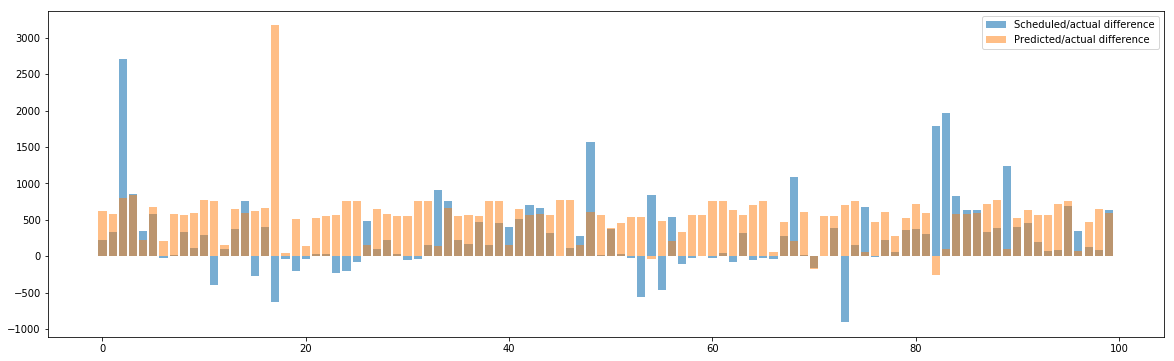

In [8]:
# A piece of data...
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.bar(results.index.values[0:100], results['ACTUAL'][0:100]-results['Sched. trip time'][0:100], label="Scheduled/actual difference", alpha=0.6)
plt.bar(results.index.values[0:100], results['Trip time'][0:100]-results['Sched. trip time'][0:100], label="Predicted/actual difference", alpha=0.5)
#plt.bar(results.index.values[0:100], results['Sched. trip time'][0:100], label="Scheduled time", alpha=1)
plt.legend()
plt.show()

In [9]:
# Add departure delay to prediction
results['delays'] = results['Trip time'] - results['Sched. trip time'] + testing['Delay at Dep.']

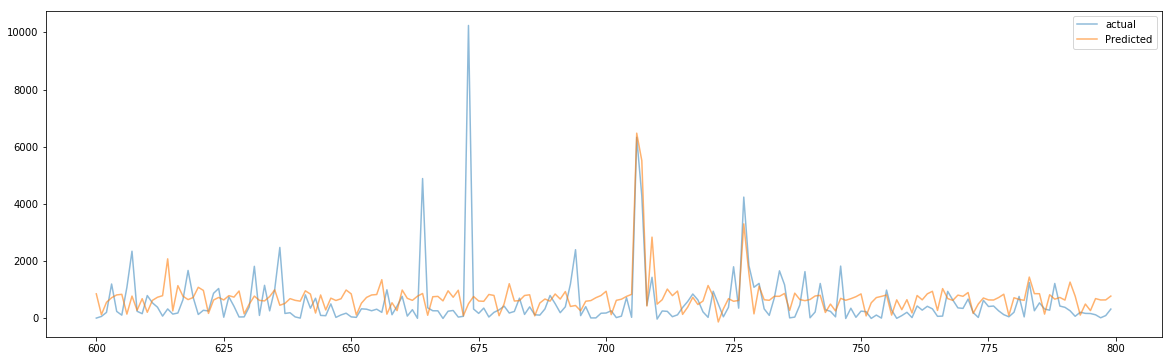

In [10]:
# A piece of data...
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.plot(results.index.values[600:800], testing['Delay'][600:800], label="actual", alpha=0.5)
plt.plot(results.index.values[600:800], results['delays'][600:800], label="Predicted", alpha=0.6)
#plt.bar(results.index.values[0:100], results['Sched. trip time'][0:100], label="Scheduled time", alpha=1)
plt.legend()
plt.show()

---
## K Nearest Neighbour Regressor

Predicting with KNN

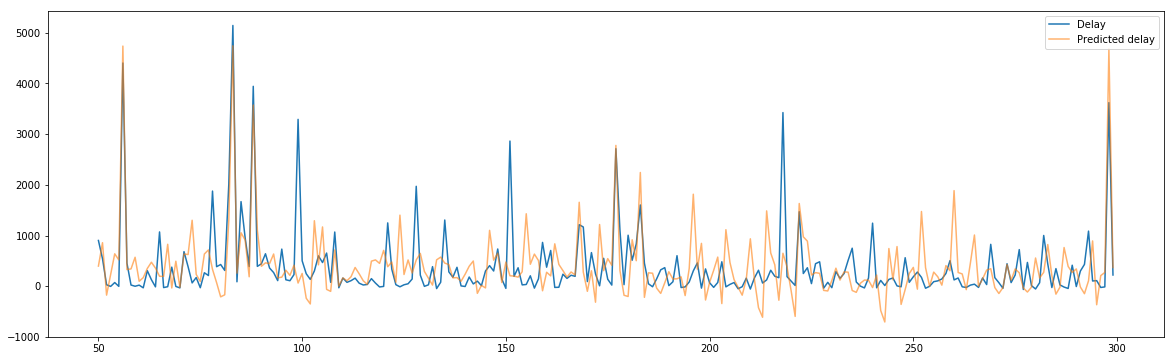

In [11]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=1, weights='distance', algorithm='auto', p=2) #'auto','ball_tree','kd_tree','brute'
neigh.fit(X, y) # use the same data as before

result = neigh.predict(testdata) # prediction with knn
 
results = testdata.copy()
results.insert(0, 'preds', result)#
results = pd.DataFrame(scaler.inverse_transform(results), columns=colnames)

# COUNT THE DELAY (SCHEDULED TIME - TRIP TIME) AND ADD DEPARTURE DELAY
results['delays'] = results['Trip time'] - results['Sched. trip time'] + testing['Delay at Dep.']

# Print score and loss
#print("Training set score: %f" % neigh.score(X, y))
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.plot(testing.index.values[50:300], testing['Delay'][50:300], label="Delay", alpha=1)
plt.plot(results.index.values[50:300], results['delays'][50:300], label="Predicted delay", alpha=0.6)
plt.legend()

plt.show()

---

## Classification. Try to predict, if a train is late or not



In [12]:
# We use the same scaled 'X' -dataframe than before, but
# for classification, we convert 'Delay' to 1's and 0's. Late = 1, Early = 0
def io(row):
    if row['Trip time'] > row['Sched. trip time']:
        return 1
    else:
        return 0

# Select training data (convert one-hot)
training2['Trip time'] = training.apply(lambda row: io(row),axis=1)

# Set target column
y = training2['Trip time']

# Convert test data's 'Delay' to 0 and 1
testing2=testing.copy()
testing2['Trip time'] = testing.apply(lambda row: io(row),axis=1)
training2.head(5)

,Trip time,Sched. trip time,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,0,-0.409216,0.461255,-1.0,-1.0,-1.0,0.086093,-1.0,-1.0,-0.939394
1,1,-0.409216,0.461255,-1.0,-1.0,-1.0,0.629139,-1.0,-1.0,-0.878788
2,1,-0.243797,0.461255,-1.0,-1.0,-1.0,0.509934,-1.0,-1.0,-0.878788
3,1,-0.243797,0.461255,-1.0,-1.0,-1.0,0.304636,-1.0,-1.0,-0.939394
4,1,-0.740055,0.453875,-1.0,-1.0,-1.0,0.066225,-1.0,-1.0,-0.939394


### K Nearest Neighbour (KNN) Classifier

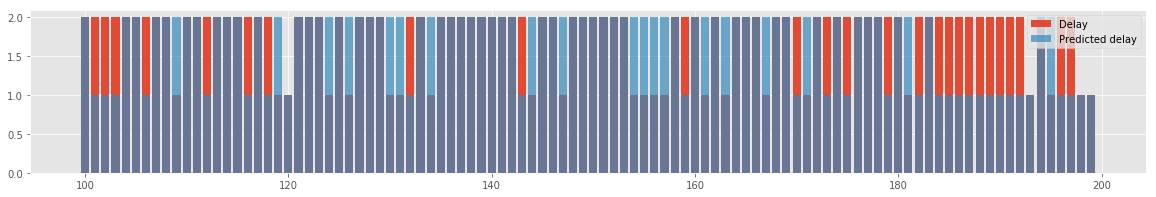

Accuracy:  515 / 854 = 0.6030444964871194 
Trains delayed   :  644 
Predicted delayed:  575


In [14]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

# Learning model
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')

# Fit he model
knn.fit(X, y)

# Predict schedule
prediction = pd.DataFrame(knn.predict(testdata))

# Visualize
fig, ax = plt.subplots()
fig.set_size_inches(20, 3)
plt.style.use('ggplot') # apply style
plt.bar(testing2.index.values[100:200], testing2['Trip time'][100:200]+1, label="Delay", alpha=1)
plt.bar(prediction.index.values[100:200], prediction[0][100:200]+1, label="Predicted delay", alpha=0.7)
plt.legend()
plt.show()

# Let's count the accuracy
correct = 0
count_ones = 0
for index, row in testing2.iterrows():
    count_ones += row['Trip time']
    if row['Trip time'] == prediction[0][index]:
        correct += 1

print("Accuracy: ", correct, "/",len(testing), "=", correct/len(testing),"\nTrains delayed   : ", 
      np.int64(count_ones), "\nPredicted delayed: ", prediction[0].value_counts()[1])